Goals
Now, let's take it one step further!

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "chat-messaging-summary"

In [3]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

We'll use MessagesState, as before.

In addition to the built-in messages key, we'll now include a custom key (summary).

In [4]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [5]:
#We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use RemoveMessage to filter our state after we've produced the summary.

In [7]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [8]:
## We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [9]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Adding memory
Recall that state is transient to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions.

As introduced at the end of Module 1, we can use persistence to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

As we previously showed, one of the easiest to work with is MemorySaver, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

In [10]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)



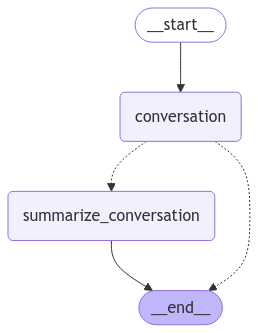

In [11]:
# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a thread of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use configurable to set a thread ID.

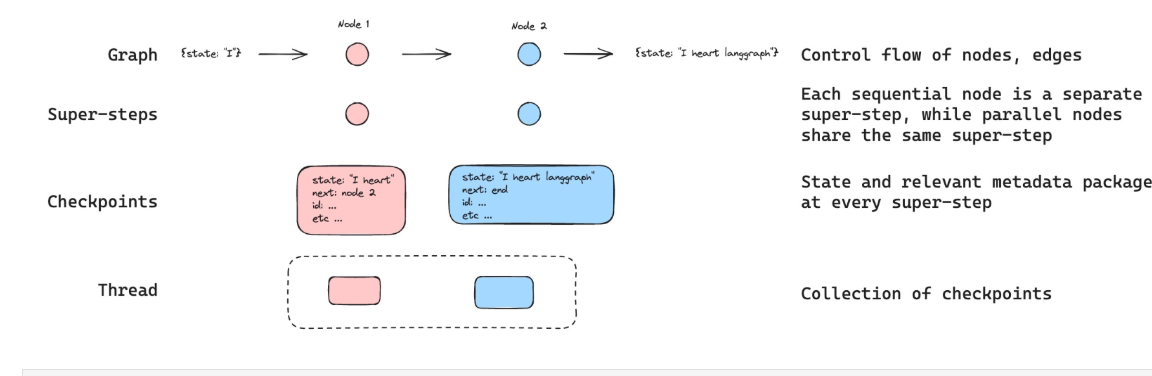

In [12]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================== Ai Message ==================================

Hello Lance! How can I assist you today?


In [14]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You mentioned earlier that your name is Lance. Is there anything else you'd like to talk about?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that stands out to you?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in should_continue.

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
We can pick up the conversation because we have the thread.

In [15]:
graph.get_state(config).values.get("summary","")

"Lance introduced himself and expressed his interest in the San Francisco 49ers. The conversation included a brief mention of the team's history and fan base. Lance also asked about his name, which he had previously stated."

In [16]:
#The config with thread ID allows us to proceed from the previously logged state!

In [17]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes, Nick Bosa became the highest-paid defensive player in NFL history in September 2023. He signed a five-year contract extension with the San Francisco 49ers worth $170 million, with $122.5 million guaranteed. Bosa has been a key player for the 49ers, known for his impressive pass-rushing abilities. It's great to hear you're a fan of his!


In [18]:
graph.get_state(config).values.get("summary","")

"Lance introduced himself and expressed his interest in the San Francisco 49ers. The conversation included a brief mention of the team's history and fan base. Lance also asked about his name, which he had previously stated."

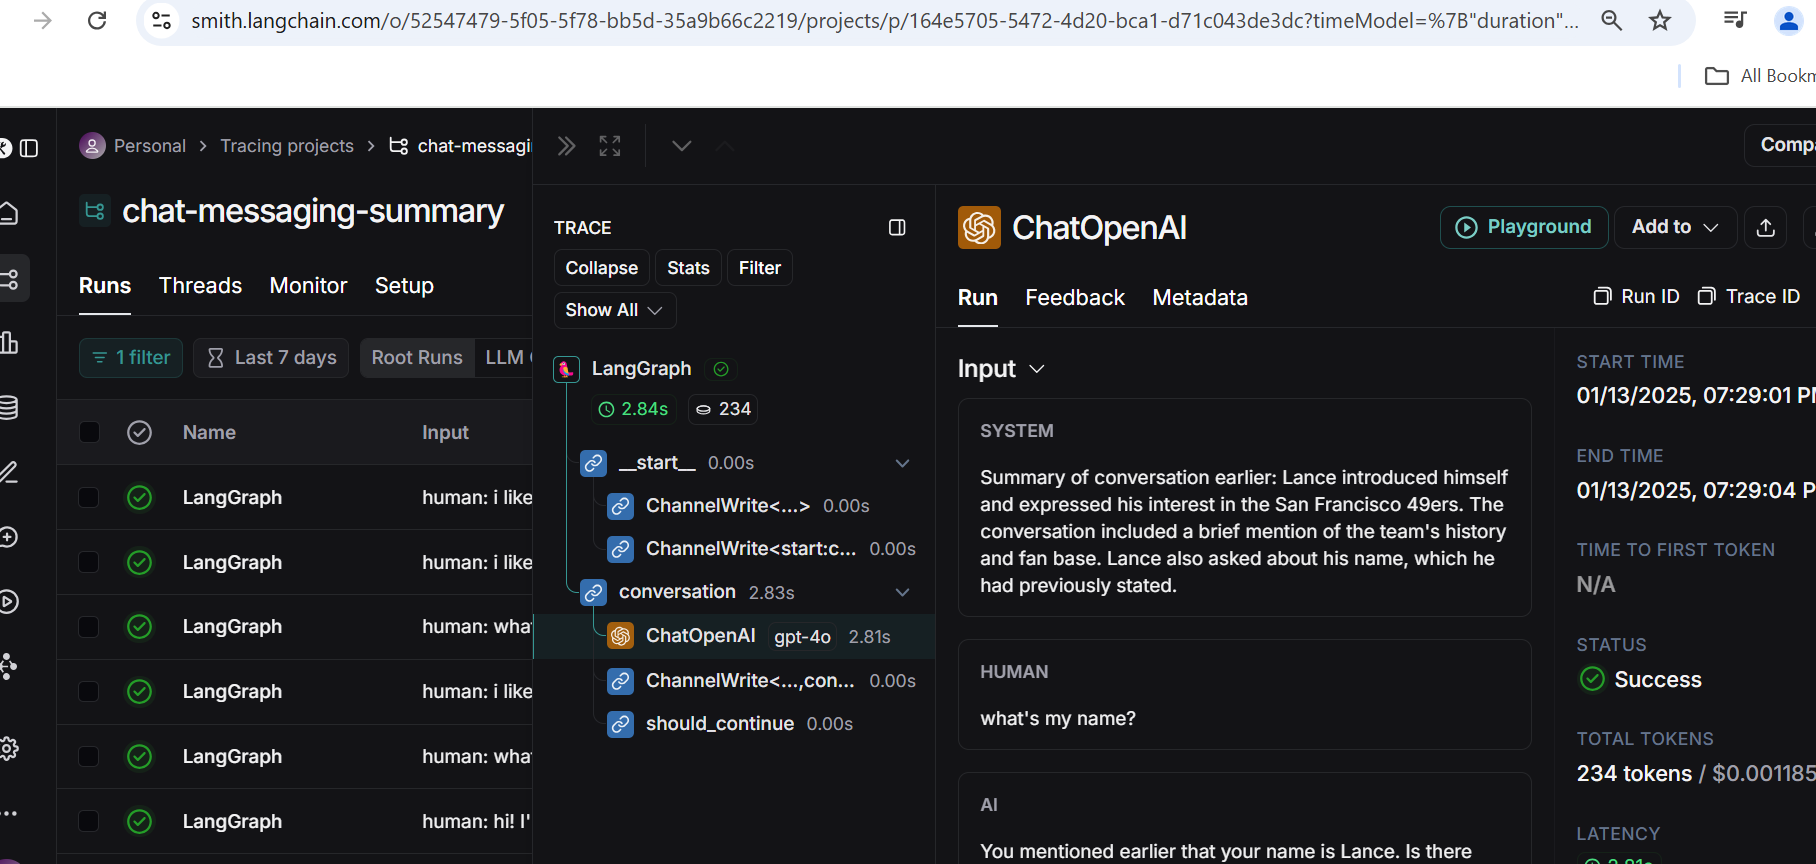

In [19]:
##  invoke anothr set of conversations for anther  channel ( config id )


# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Asmita Chatterjee")
output = graph.invoke({"messages": [input_message]}, config) 


In [20]:
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, Asmita Chatterjee! How can I assist you today?


In [21]:
# Start conversation
input_message = HumanMessage(content="What is my name ? can you pronounce loudly?")
output = graph.invoke({"messages": [input_message]}, config) 

In [22]:
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

I'm unable to speak out loud, but I can confirm that your name is Asmita Chatterjee. If there's anything else you'd like to know or discuss, feel free to ask!


In [23]:
# Start conversation
input_message = HumanMessage(content="Who is the present CEO of IBM? ")

In [24]:
input_message

HumanMessage(content='Who is the present CEO of IBM? ', additional_kwargs={}, response_metadata={})

In [25]:
output = graph.invoke({"messages": [input_message]}, config) 

In [26]:
for m in output['messages']:#[-1:]:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Asmita Chatterjee
================================== Ai Message ==================================

Hello, Asmita Chatterjee! How can I assist you today?
================================ Human Message =================================

What is my name ? can you pronounce loudly?
================================== Ai Message ==================================

I'm unable to speak out loud, but I can confirm that your name is Asmita Chatterjee. If there's anything else you'd like to know or discuss, feel free to ask!
================================ Human Message =================================

Who is the present CEO of IBM? 
================================== Ai Message ==================================

As of the latest information available, the CEO of IBM is Arvind Krishna. He became the CEO in April 2020. Please verify with a current source to ensure this information is still accurate.


In [27]:
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

As of the latest information available, the CEO of IBM is Arvind Krishna. He became the CEO in April 2020. Please verify with a current source to ensure this information is still accurate.


In [28]:
# Start conversation
input_message = HumanMessage(content="When was he born and exactly where ? ")
output = graph.invoke({"messages": [input_message]}, config) 

In [29]:
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Arvind Krishna was born in 1962 in West Godavari district, Andhra Pradesh, India.


In [30]:
graph.get_state(config).values.get("summary","")

"In the conversation, the user, Asmita Chatterjee, introduced themselves and asked the assistant to confirm their name. They then inquired about the current CEO of IBM, to which the assistant responded that Arvind Krishna is the CEO as of the latest information. The user further asked about Arvind Krishna's birth details, and the assistant provided that he was born in 1962 in West Godavari district, Andhra Pradesh, India."

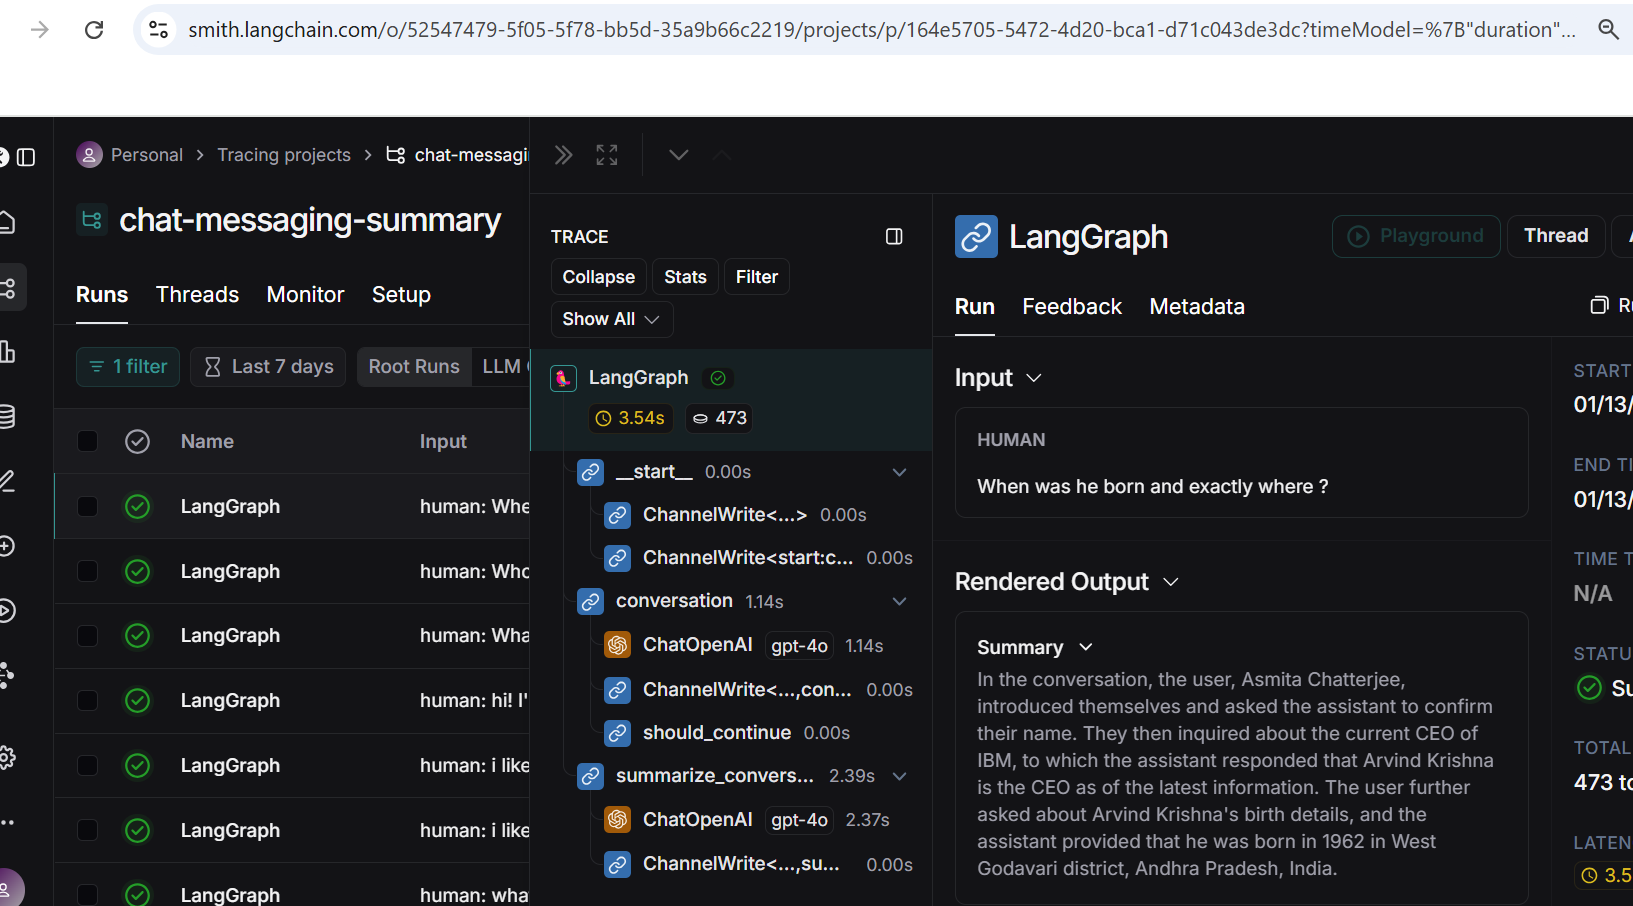

In [31]:
# Start conversation
input_message = HumanMessage(content="Who was the CEO  before him? ? ")
output = graph.invoke({"messages": [input_message]}, config) 

In [32]:
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Before Arvind Krishna, the CEO of IBM was Ginni Rometty. She served as CEO from January 2012 until April 2020.


In [33]:
graph.get_state(config).values.get("summary","")

"In the conversation, the user, Asmita Chatterjee, introduced themselves and asked the assistant to confirm their name. They then inquired about the current CEO of IBM, to which the assistant responded that Arvind Krishna is the CEO as of the latest information. The user further asked about Arvind Krishna's birth details, and the assistant provided that he was born in 1962 in West Godavari district, Andhra Pradesh, India."

In [34]:
# Start conversation
input_message = HumanMessage(content="Where did she study? ")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Ginni Rometty studied at Northwestern University, where she earned a Bachelor of Science degree in computer science and electrical engineering in 1979.


In [35]:
graph.get_state(config).values.get("summary","")

"In the conversation, the user, Asmita Chatterjee, introduced themselves and asked the assistant to confirm their name. They then inquired about the current CEO of IBM, to which the assistant responded that Arvind Krishna is the CEO as of the latest information. The user further asked about Arvind Krishna's birth details, and the assistant provided that he was born in 1962 in West Godavari district, Andhra Pradesh, India."